# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues
- Alexandre Gonçalves
- Pedro Costa
- Santiago Taylor
- Lena Hermann

# Notebook 04 - Modeling and Assessment

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
&nbsp;&nbsp;&nbsp;[1.1 Import the Needed Libraries](#import_libaries) <br>
&nbsp;&nbsp;&nbsp;[1.2 Define Functions](#functions) <br>
&nbsp;&nbsp;&nbsp;[1.3 Load the Data](#load_data) <br>
&nbsp;&nbsp;&nbsp;[1.4 Class Imbalance Mitigation](#adasyn) <br>
[2. Modeling and Evaluation](#modeling) <br>
&nbsp;&nbsp;&nbsp;[2.1 Baseline](#baseline) <br>
&nbsp;&nbsp;&nbsp;[2.2 Logistic Regression](#logistic_regression) <br>
&nbsp;&nbsp;&nbsp;[2.3 Naive Bayes](#nb) <br>
&nbsp;&nbsp;&nbsp;[2.4 K-Nearest Neighbors](#knn) <br>
&nbsp;&nbsp;&nbsp;[2.5 Neural Networks](#nn) <br>
&nbsp;&nbsp;&nbsp;[2.6 Decision Trees](#dt) <br>
&nbsp;&nbsp;&nbsp;[2.7 Ensemble Learning](#el) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.1 Bagging Classifier](#bagging) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.2 Random Forest Classifier](#random_forest) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7.3 XGBoost](#xgboost) <br>
&nbsp;&nbsp;&nbsp;[2.8 Support Vector Machines](#svm) <br>
[3. Comparison of all Models](#comparison) <br>
[4. Feature Importance](#feature_importance) <br>
[5. Best Model vs. Stacking](#stacking) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the Needed Libraries <a id='import_libaries'></a>

In [3]:
# Core Functions
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
from scipy.stats import mode


# Model Selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

# Addressing Imbalance
from imblearn.over_sampling import ADASYN

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Model Assessment
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set a global seed
np.random.seed(42)

### 1.2 Define Functions <a id='functions'></a>

In [5]:
# Define functions to use as pipeline

# Training and Evaluation
def train_and_evaluate(model, X_train, X_val, y_train, y_val):
    """
    Train and evaluate a single model on a fixed training and validation set.

    Parameters:
        model: The machine learning model to train.
        X_train (pd.DataFrame): Training feature set.
        X_val (pd.DataFrame): Validation feature set.
        y_train (pd.Series): Training labels.
        y_val (pd.Series): Validation labels.

    Returns:
        dict: A dictionary containing training time, train F1-score, and validation F1-score.
    """

    # Training and timing
    start = time.perf_counter()
    model.fit(X_train, y_train)
    end = time.perf_counter()

    # Predictions and scoring
    train_f1 = round(f1_score(y_train, model.predict(X_train), average='macro'), 3)
    val_f1 = round(f1_score(y_val, model.predict(X_val), average='macro'), 3)
    elapsed_time = round(end - start, 3)

    return elapsed_time, train_f1, val_f1


def compare_results(models, X_train, X_val, y_train, y_val):
    """
    Evaluate multiple models using cross-validation and return results in a DataFrame.
    """
    results = []
    for name, model in models:
        print(f"Evaluating model: {name}...")
        time, train_f1, val_f1 = train_and_evaluate(model, X_train, X_val, y_train, y_val)
        results.append({
            "Model": name,
            "Time (s)": time,
            "Train F1-Score": train_f1,
            "Validation F1-Score": val_f1
        })

    results_df = pd.DataFrame(results)
    return results_df


# Comined Dataset
def create_combined_dataset(X_train, X_val, y_train, y_val):
    """
    Combines train and validation datasets and creates a test fold index.
    """
    # Combine train and validation datasets
    X_combined = np.concatenate([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    
    # Create a test fold index (-1 for train, 0 for validation)
    test_fold = [-1] * len(X_train) + [0] * len(X_val)
    
    # Print debug information
    print('Test fold: ', len(test_fold))
    print('X_combined: ', len(X_combined))
    print('y_combined: ', len(y_combined))
    
    return X_combined, y_combined, test_fold


# Hyperparameter Tuning
def hyperparameter_tuning(estimator, param_grid, test_fold, X_combined, y_combined):
    """Perform hyperparameter tuning with Predefined Split"""
    ps = PredefinedSplit(test_fold=test_fold)
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1_macro', verbose=1, cv=ps)
    grid_search.fit(X_combined, y_combined)
    print(f"The best score is {grid_search.best_score_}")
    print(f"With the parameters: {grid_search.best_params_}")
    return grid_search.best_params_


# Evaluation Functions
def classification_report_print(y_test, y_pred, model):
    """Print classification report."""
    print("\nClassification Report for {}:".format(model))
    print('')
    print(classification_report(y_test, y_pred))

def conf_matrix_plot(y_true, y_pred):
    """Plot confusion matrix."""
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    cnf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    df_cm = pd.DataFrame(cnf_matrix, index=unique_labels, columns=unique_labels)
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()



### 1.3 Load the Data <a id='load_data'></a>
[to the top](#top)

In [6]:
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

test_df = read_zipped_csv(test_zip_path)

In [7]:
test_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1
2,2022-12-26,59,N,2023-01-02,N,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0
3,2022-12-28,55,N,2023-01-02,N,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6
4,2022-12-20,25,N,2023-01-02,N,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5


In [8]:
# Load the feature datasets
X_train = pd.read_csv("model_input_files/X_train_final_features.csv")
X_val = pd.read_csv("model_input_files/X_val_final_features.csv")
X_test = pd.read_csv("model_input_files/X_test_final_features.csv")

# Load the submission test data set
X_test_submission = pd.read_csv("model_input_files/X_test_submission_final_features.csv")

# Load the target datasets
y_train = pd.read_csv("preprocessed_files/y_train_encoded_median.csv")
y_val = pd.read_csv("preprocessed_files/y_val_encoded_median.csv")
y_test = pd.read_csv("preprocessed_files/y_test_encoded_median.csv")


# Inspect loaded data
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
print("X_test_submission shape:", X_test_submission.shape)

X_train shape: (346576, 45) y_train shape: (346576, 1)
X_val shape: (91844, 45) y_val shape: (91844, 1)
X_test shape: (114806, 45) y_test shape: (114806, 1)
X_test_submission shape: (387975, 45)


In [9]:
X_train.head()

,Age at Injury,Average Weekly Wage,Claim Identifier,Number of Dependents,Accident_to_C2_Lag,Accident Date_Month,Accident_Day,Accident_Month_Cos,Assembly Date_Day,C-2 Date_Day,Attorney/Representative_N,COVID-19 Indicator_N,Body Part Category_Abdomen and Pelvis,Body Part Category_Ankle and Foot,Body Part Category_Arm and Wrist,Body Part Category_Body Systems,Body Part Category_Chest,Body Part Category_Hand and Fingers,Body Part Category_Head and Face,Body Part Category_Heart,Body Part Category_Hip,Body Part Category_Internal Organs,Body Part Category_Knee,Body Part Category_Leg,Body Part Category_Lower Back,Body Part Category_Lungs,Body Part Category_Neck and Throat,Body Part Category_Other,Body Part Category_Shoulder,Body Part Category_Soft Tissue,Body Part Category_Spinal Column,Body Part Category_Unclassified or Insufficient Info,Body Part Category_Upper Back,Carrier Name Grouped_A I U INSURANCE COMPANY,Carrier Name Grouped_AMERICAN ZURICH INSURANCE CO,Carrier Name Grouped_CHARTER OAK FIRE INS CO,Carrier Name Grouped_INDEMNITY INS. OF N AMERICA,Carrier Name Grouped_INDEMNITY INSURANCE CO OF,Carrier Name Grouped_LM INSURANCE CORP,Carrier Name Grouped_NEW HAMPSHIRE INSURANCE CO,Carrier Name Grouped_NYC TRANSIT AUTHORITY,Carrier Name Grouped_Other,"Carrier Name Grouped_POLICE, FIRE, SANITATION",Carrier Name Grouped_SAFETY NATIONAL CASUALTY CORP,Carrier Name Grouped_STATE INSURANCE FUND
0,-1.182536,-0.632462,0.880103,-1.502617,0.039054,-1.585308,-0.275587,1.217411,-0.700776,-0.099383,-1.541767,0.22204,-0.125689,-0.306375,-0.294155,-0.252189,-0.11822,-0.408639,-0.255723,-0.033218,-0.105751,-0.080347,-0.300649,-0.170577,-0.324213,-0.155622,-0.073535,2.392737,-0.263567,-0.19094,-0.061408,-0.142915,-0.121147,-0.136551,-0.180054,-0.17827,-0.161493,-0.12791,-0.146592,-0.151518,-0.1158,-1.145716,-0.189662,-0.160352,2.039097
1,1.212683,0.809764,0.116911,1.496494,0.132213,0.434498,-0.826830,-0.722067,-0.700776,-0.785048,0.648606,0.22204,-0.125689,-0.306375,3.399574,-0.252189,-0.11822,-0.408639,-0.255723,-0.033218,-0.105751,-0.080347,-0.300649,-0.170577,-0.324213,-0.155622,-0.073535,-0.417931,-0.263567,-0.19094,-0.061408,-0.142915,-0.121147,-0.136551,-0.180054,-0.17827,-0.161493,-0.12791,-0.146592,-0.151518,-0.1158,-1.145716,-0.189662,-0.160352,2.039097
2,-1.255119,1.316476,0.388915,1.496494,0.389202,1.300129,1.378143,1.217411,1.383737,1.271948,-1.541767,0.22204,-0.125689,-0.306375,-0.294155,-0.252189,-0.11822,-0.408639,-0.255723,-0.033218,-0.105751,-0.080347,3.326140,-0.170577,-0.324213,-0.155622,-0.073535,-0.417931,-0.263567,-0.19094,-0.061408,-0.142915,-0.121147,-0.136551,-0.180054,-0.17827,-0.161493,-0.12791,-0.146592,-0.151518,-0.1158,-1.145716,-0.189662,-0.160352,2.039097
3,-1.255119,-0.632462,0.884552,1.496494,0.877480,-0.719677,1.929386,-0.722067,-0.005938,-0.099383,0.648606,0.22204,-0.125689,-0.306375,-0.294155,-0.252189,-0.11822,-0.408639,-0.255723,-0.033218,-0.105751,-0.080347,-0.300649,-0.170577,3.084389,-0.155622,-0.073535,-0.417931,-0.263567,-0.19094,-0.061408,-0.142915,-0.121147,-0.136551,-0.180054,-0.17827,-0.161493,-0.12791,-0.146592,-0.151518,-0.1158,0.872817,-0.189662,-0.160352,-0.490413
4,-1.690613,-0.632462,-1.037381,-1.002766,-1.062785,0.434498,0.826900,-0.722067,-1.395614,-1.470714,0.648606,0.22204,-0.125689,3.263975,-0.294155,-0.252189,-0.11822,-0.408639,-0.255723,-0.033218,-0.105751,-0.080347,-0.300649,-0.170577,-0.324213,-0.155622,-0.073535,-0.417931,-0.263567,-0.19094,-0.061408,-0.142915,-0.121147,-0.136551,-0.180054,-0.17827,6.192205,-0.12791,-0.146592,-0.151518,-0.1158,-1.145716,-0.189662,-0.160352,-0.490413


In [10]:
X_train.columns

Index(['Age at Injury', 'Average Weekly Wage', 'Claim Identifier',
       'Number of Dependents', 'Accident_to_C2_Lag', 'Accident Date_Month',
       'Accident_Day', 'Accident_Month_Cos', 'Assembly Date_Day',
       'C-2 Date_Day', 'Attorney/Representative_N', 'COVID-19 Indicator_N',
       'Body Part Category_Abdomen and Pelvis',
       'Body Part Category_Ankle and Foot', 'Body Part Category_Arm and Wrist',
       'Body Part Category_Body Systems', 'Body Part Category_Chest',
       'Body Part Category_Hand and Fingers',
       'Body Part Category_Head and Face', 'Body Part Category_Heart',
       'Body Part Category_Hip', 'Body Part Category_Internal Organs',
       'Body Part Category_Knee', 'Body Part Category_Leg',
       'Body Part Category_Lower Back', 'Body Part Category_Lungs',
       'Body Part Category_Neck and Throat', 'Body Part Category_Other',
       'Body Part Category_Shoulder', 'Body Part Category_Soft Tissue',
       'Body Part Category_Spinal Column',
       'Body 

In [11]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [12]:
# Define the mapping for the target variable
target_mapping = {
    '1. CANCELLED': 0,
    '2. NON-COMP': 1,
    '3. MED ONLY': 2,
    '4. TEMPORARY': 3,
    '5. PPD SCH LOSS': 4,
    '6. PPD NSL': 5,
    '7. PTD': 6,
    '8. DEATH': 7
}

# Invert the mapping for reverse transformation
inverse_target_mapping = {v: k for k, v in target_mapping.items()}

In [13]:
y_test = y_test['Claim Injury Type']
y_test_decoded = y_test.map(inverse_target_mapping)

### 1.4 Class Imbalance Mitigation - ADASYN <a id='adasyn'></a>
[to the top](#top)

The dataset presents a __class imbalance__ problem, which can lead to biased model predictions and poor performance on minority classes. To mitigate this issue, we apply __ADASYN (Adaptive Synthetic Sampling)__, a technique that generates synthetic samples for underrepresented classes based on data density. This approach ensures a more balanced training set, improving the model's ability to generalize across all classes.

In [14]:
# Initialize ADASYN with your desired random state
adasyn = ADASYN(random_state=42)

# Define custom sampling strategy
sampling_strategy = {
    1: 183163,   # No oversampling for the largest class
    3: 150000,   # Moderate oversampling
    2: 120000,
    4: 100000,
    0: 80000,
    5: 50000,
    7: 20000,
    6: 10000
}

# Apply ADASYN with the custom sampling strategy
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

In [15]:
# Check class distribution before ADASYN
print("Class distribution before ADASYN:\n", y_train.value_counts())

Class distribution before ADASYN:
 Claim Injury Type
1                    183163
3                     85951
2                     41949
4                     26220
0                      6552
5                      2417
7                       271
6                        53
dtype: int64


In [16]:
# Check class distribution after ADASYN
print("Class distribution after ADASYN:\n", y_train_adasyn.value_counts())

Class distribution after ADASYN:
 Claim Injury Type
1                    183163
3                    148447
2                    118292
4                    101443
0                     79434
5                     50548
7                     19996
6                     10017
dtype: int64


#### Combine Train and Validation Datasets

Since we use the Hold-out method, we combine the train and validation datasets again to use them in the modeling part for performing hyperparameter tuning with this predefined split.

In [17]:
X_combined, y_combined, test_fold = create_combined_dataset(X_train, X_val, y_train, y_val)

Test fold:  438420
X_combined:  438420
y_combined:  438420


In [18]:
X_combined_adasyn, y_combined_adasyn, test_fold = create_combined_dataset(X_train_adasyn, X_val, y_train_adasyn, y_val)

Test fold:  803184
X_combined:  803184
y_combined:  803184


## 2. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

In this section, we focus on building and evaluating various machine learning models to address our classification problem. The input for the models used the preprocessing and encoding pipeline with __median imputation__ for handling missing values and __Standard Scaling__ to normalize the features. Multiple model configurations, hyperparameter tuning, and preprocessing strategies were tested to determine the optimal approach. A detailed comparison of the results can be found in the final report. Eventhough introducing ADASYN in this notebook, the run we are showing here did not use it. The results using ADASYN can also be found in the final report.

### 2.1 Baseline <a id='baseline'></a>
[to the top](#top)

To establish a benchmark for model performance, we start with a __baseline model__ that predicts the __majority class__ for all instances. This simplistic approach provides a reference point, helping us assess whether more complex models offer meaningful improvements over random or naive predictions.

In [19]:
# Predict the majority class for all instances as baseline
majority_class = mode(y_train)[0][0].item() 

y_pred_baseline = [majority_class] * len(y_test)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
print(f"Baseline Model F1 Score (predicting majority class): {baseline_f1:.2f}")

# Decoding the predictions (reverse transformation)
y_pred_baseline_original = [inverse_target_mapping[val] for val in y_pred_baseline]

# Classification report with the original labels
classification_report_print(y_test_decoded, y_pred_baseline_original, 'Baseline Model')

Baseline Model F1 Score (predicting majority class): 0.08

Classification Report for Baseline Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00      2496
    2. NON-COMP       0.51      1.00      0.67     58216
    3. MED ONLY       0.00      0.00      0.00     13781
   4. TEMPORARY       0.00      0.00      0.00     29702
5. PPD SCH LOSS       0.00      0.00      0.00      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.51    114806
      macro avg       0.06      0.12      0.08    114806
   weighted avg       0.26      0.51      0.34    114806



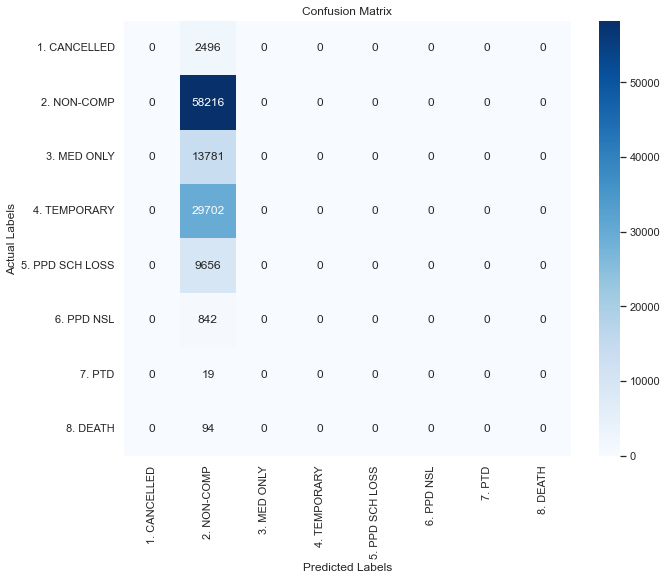

In [20]:
# Plot confusion matrix
conf_matrix_plot(y_test_decoded, y_pred_baseline_original)

### 2.2 Logistic Regression <a id='logistic_regression'></a>
[to the top](#top)

Step 1: Create model and define hyperparameter grid for Logistic Regression

In [21]:
# Create model
model_lr_default = LogisticRegression(multi_class='multinomial')
model_lr = LogisticRegression(multi_class='multinomial', C= 10, max_iter=500, solver='lbfgs')

# Define hyperparameter grid
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10, 100],               # Regularization strength (smaller values mean stronger regularization)
    "solver": ["lbfgs", "saga", "newton-cg"],   # Solvers that support multinomial logistic regression
    "max_iter": [100, 500, 1000]                # Maximum number of iterations for solver convergence
}

Step 2: Perform hyperparameter tuning

In [22]:
# Tune hyperparameters using the combined dataset
best_params_lr = hyperparameter_tuning(model_lr, param_grid_lr, test_fold, X_combined, y_combined)
model_lr.set_params(**best_params_lr)

Fitting 1 folds for each of 45 candidates, totalling 45 fits
The best score is 0.2774515071512479
With the parameters: {'C': 10, 'max_iter': 500, 'solver': 'lbfgs'}



LogisticRegression(C=10, max_iter=500, multi_class='multinomial')

Step 3: Train default model and model with best parameter setting and evaluate

In [23]:
models_lr = [
    ("LR Default", model_lr_default),
    ("LR Best Params", model_lr)
]

In [24]:
# Train and evaluate on validation set
results_lr = compare_results(models_lr, X_train, X_val, y_train, y_val)
results_lr

Evaluating model: LR Default...
Evaluating model: LR Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,LR Default,7.455,0.276,0.277
1,LR Best Params,7.628,0.277,0.277


Step 4: Evaluate the choosen Model on our Test Set

In [25]:
# Evaluate on the test set
y_test_pred_lr = model_lr.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_lr = [inverse_target_mapping[val] for val in y_test_pred_lr]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_lr_best = round(f1_score(y_test_decoded, y_test_pred_decoded_lr, average='macro'), 3)
results_lr_best = results_lr[results_lr["Model"].str.contains("Best Params")].copy()
results_lr_best["Test F1-Score"] = test_f1_lr_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_lr, 'Logistic Regression Model')


Classification Report for Logistic Regression Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.16      0.01      0.03      2496
    2. NON-COMP       0.80      0.99      0.89     58216
    3. MED ONLY       0.21      0.02      0.04     13781
   4. TEMPORARY       0.70      0.80      0.74     29702
5. PPD SCH LOSS       0.63      0.46      0.53      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.75    114806
      macro avg       0.31      0.29      0.28    114806
   weighted avg       0.67      0.75      0.69    114806



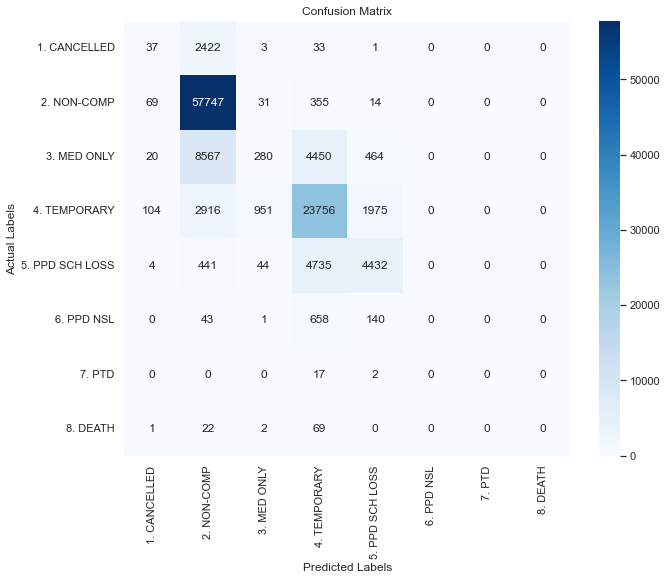

In [26]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_lr)

__Findings:__
- __Dominant Predictions in Major Classes:__ The model exhibits a strong bias toward predicting the "NON-COMP" and "TEMPORARY" classes, which make up the majority of the dataset. This bias results in a __high precision (0.80) and recall (0.99)__ for __"NON-COMP"__, and similarly strong performance for __"TEMPORARY" (F1-Score = 0.74)__. While this improves the overall accuracy (75%), it highlights the model’s tendency to prioritize majority classes at the expense of underrepresented ones.
- __Poor Performance in Minority Classes:__ Predictions for minority classes, such as __"CANCELLED", "PTD", and "DEATH"__, remain highly inaccurate. The F1-Scores for these classes are __0.03, 0.00, and 0.00__, respectively. This indicates that the model struggles to learn meaningful patterns for rare categories, likely due to the class imbalance in the data. For example, "CANCELLED" achieves only 1% recall, meaning almost all its instances are misclassified, often as "NON-COMP" or "TEMPORARY".
- __Overlapping Classes and Misclassification Patterns:__ The confusion between classes such as _"MED ONLY" and "TEMPORARY"_ highlights potential overlap in feature distributions or similarities in patterns for these categories. _"PPD SCH LOSS"_ also shows moderate confusion with _"TEMPORARY"_ due to its slightly higher F1-Score (0.53) compared to other minority classes. This suggests that additional feature engineering or dimensionality reduction might help separate these classes more effectively.
- __Macro vs. Weighted Performance:__ While the __weighted average F1-Score is 0.69__, reflecting performance weighted by class sizes, the __macro-average F1-Score is much lower (0.28)__. This disparity further highlights that the model disproportionately favors majority classes and fails to generalize well across all categories

Step 5: Prediction on Submission Test Data

In [27]:
# Predict on the test set
y_test_sub_pred_lr = model_lr.predict(X_test_submission)
y_test_sub_pred_decoded_lr = [inverse_target_mapping[val] for val in y_test_sub_pred_lr]
#y_test_sub_pred_decoded_lr

In [28]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_lr, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 2600
2. NON-COMP: 329228
3. MED ONLY: 7464
4. TEMPORARY: 47428
5. PPD SCH LOSS: 1255


In [29]:
# Create a submission DataFrame
submission_lr = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_lr
})

# Save the submission file
submission_lr.to_csv('submissions/Group52_VersionX_lr.csv', index=False)
print("Submission file saved as 'Group52_VersionX_lr.csv'")

Submission file saved as 'Group52_VersionX_lr.csv'


In [30]:
submission_lr

,Claim Identifier,Prediction
0,6165911,2. NON-COMP
1,6166141,2. NON-COMP
2,6165907,2. NON-COMP
3,6166047,2. NON-COMP
4,6166102,2. NON-COMP
...,...,...
387970,6553137,1. CANCELLED
387971,6553119,1. CANCELLED
387972,6553542,1. CANCELLED
387973,6553455,1. CANCELLED


### 2.3 Naive Bayes <a id='nb'></a>
[to the top](#top)

For Naive Bayes, we primarily employed the Gaussian Naive Bayes model, while the Multinomial Naive Bayes model was tested when using Min-Max scaling.

Step 1: Create models and define hyperparameter grid for Naive Bayes

In [31]:
# Create model
model_gauss_nb_default = GaussianNB()
model_gauss_nb = GaussianNB(var_smoothing=1e-7)
#model_multi_nb_default = MultinomialNB()
#model_multi_nb = MultinomialNB()

# Define hyperparameter grid
param_grid_gauss = {
    "var_smoothing": [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]  #
}

# Define hyperparameter grid
param_grid_multi = {
    "alpha": [0.01, 0.1, 1, 10, 100],  # Laplace smoothing parameter
    "fit_prior": [True, False]         # Whether to learn class priors or use uniform distribution
}

Step 2: Perform hyperparameter tuning

In [32]:
# Tune hyperparameters using the combined dataset
best_params_gauss_nb = hyperparameter_tuning(model_gauss_nb, param_grid_gauss, test_fold, X_combined, y_combined)
model_gauss_nb.set_params(**best_params_gauss_nb)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
The best score is 0.0704181724028672
With the parameters: {'var_smoothing': 1e-07}



GaussianNB(var_smoothing=1e-07)

In [33]:
# Tune hyperparameters using the combined dataset
#best_params_multi_nb = hyperparameter_tuning(model_multi_nb, param_grid_multi, test_fold, X_combined, y_combined)
#model_multi_nb.set_params(**best_params_multi_nb)

Step 3: Train default model and model with best parameter setting and evaluate

In [34]:
models_nb = [
    ("Gaussian NB Default", model_gauss_nb_default),
    ("Gaussian NB Best Params", model_gauss_nb),
    #("Multinomial NB Default", model_multi_nb_default),
    #("Multinomial NB Best Params", model_multi_nb)
]

In [35]:
# Train and evaluate on validation set
results_nb = compare_results(models_nb, X_train, X_val, y_train, y_val)
results_nb

Evaluating model: Gaussian NB Default...


Evaluating model: Gaussian NB Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,Gaussian NB Default,0.154,0.063,0.063
1,Gaussian NB Best Params,0.106,0.070,0.070


Step 4: Evaluate the choosen Model on our Test Set

In [36]:
# Evaluate on the test set
y_test_pred_nb = model_gauss_nb.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_nb = [inverse_target_mapping[val] for val in y_test_pred_nb]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_nb_best = round(f1_score(y_test_decoded, y_test_pred_decoded_nb, average='macro'), 3)
results_nb_best = results_nb[results_nb["Model"].str.contains("Best Params")].copy()
results_nb_best["Test F1-Score"] = test_f1_nb_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_nb, 'Naive Bayes Model')


Classification Report for Naive Bayes Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.03      0.00      0.01      2496
    2. NON-COMP       0.87      0.14      0.24     58216
    3. MED ONLY       0.22      0.02      0.04     13781
   4. TEMPORARY       0.62      0.06      0.12     29702
5. PPD SCH LOSS       0.08      0.36      0.13      9656
     6. PPD NSL       0.04      0.03      0.04       842
         7. PTD       0.00      0.74      0.00        19
       8. DEATH       0.00      0.21      0.00        94

       accuracy                           0.12    114806
      macro avg       0.23      0.20      0.07    114806
   weighted avg       0.63      0.12      0.17    114806



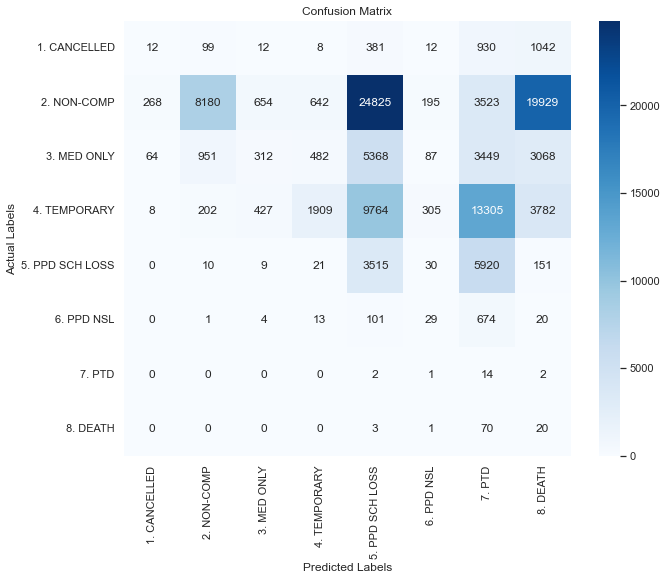

In [37]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_nb)

__Findings:__
- __Severe Bias Toward Majority Classes:__ The Gaussian Naive Bayes model demonstrates a strong bias toward the __"NON-COMP"__ class, resulting in a relatively __high precision (0.87)__ but poor __recall (0.14)__ for this majority class. This behavior inflates the weighted average F1-Score (0.17), even though the more important score for us, the __macro-average F1-Score__, remains very low __(0.07)__. The performance highlights the model's inability to handle class imbalance effectively.
- __Extremely Poor Minority Class Performance:__ The model completely fails to classify minority classes such as __"CANCELLED", "PTD", and "DEATH"__, with __F1-Scores of 0.01, 0.00, and 0.00__, respectively. Despite slightly better performance for "PPD SCH LOSS" (F1-Score = 0.13), this still falls short of acceptable performance levels. Most minority classes are frequently misclassified as "NON-COMP" or "TEMPORARY," as seen in the confusion matrix.
- __Misclassifications and Class Overlaps:__ The confusion matrix reveals significant misclassifications between _"MED ONLY" and "TEMPORARY_," as well as _"PPD SCH LOSS" and "TEMPORARY."_ For example, "PPD SCH LOSS" is often confused with "TEMPORARY" due to overlapping feature distributions. The high off-diagonal values emphasize the model's struggles in distinguishing between classes with similar characteristics.

Step 5: Prediction on Submission Test Data

In [38]:
# Predict on the submission test set
y_test_sub_pred_nb = model_gauss_nb.predict(X_test_submission)
y_test_sub_pred_decoded_nb = [inverse_target_mapping[val] for val in y_test_sub_pred_nb]

In [39]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_nb, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 1149
2. NON-COMP: 42042
3. MED ONLY: 4228
4. TEMPORARY: 7337
5. PPD SCH LOSS: 153895
6. PPD NSL: 1488
7. PTD: 66142
8. DEATH: 111694


In [40]:
# Create a submission DataFrame
submission_nb = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_nb
})

# Save the submission file
submission_nb.to_csv('submissions/Group52_VersionX_nb.csv', index=False)
print("Submission file saved as 'Group52_VersionX_nb.csv'")

Submission file saved as 'Group52_VersionX_nb.csv'


### 2.4 K-Nearest Neighbor <a id='knn'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for K-Nearest Neighbor

In [41]:
# Create KNN model
model_knn_default = KNeighborsClassifier()
model_knn = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=5, weights='uniform')

# Define parameter grid
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "algorithm": ['auto','kd_tree','brute'],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

Step 2: Perform hyperparameter tuning

In [42]:
# Tune hyperparameters using the combined dataset
best_params_knn = hyperparameter_tuning(model_knn, param_grid_knn, test_fold, X_combined, y_combined)
model_knn.set_params(**best_params_knn)

Fitting 1 folds for each of 60 candidates, totalling 60 fits
The best score is 0.31127213142501414
With the parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}



KNeighborsClassifier(metric='euclidean')

Step 3: Train default model and model with best parameter setting and evaluate

In [43]:
models_knn = [
    ("KNN Default", model_knn_default),
    ("KNN Best Params", model_knn)
]

In [44]:
# Train and evaluate on validation set
results_knn = compare_results(models_knn, X_train, X_val, y_train, y_val)
results_knn

Evaluating model: KNN Default...


Evaluating model: KNN Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,KNN Default,0.031,0.389,0.305
1,KNN Best Params,0.129,0.389,0.305


Step 4: Evaluate the choosen Model on our Test Set

In [45]:
# Evaluate on the test set
y_test_pred_knn = model_knn.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_knn = [inverse_target_mapping[val] for val in y_test_pred_knn]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_knn_best = round(f1_score(y_test_decoded, y_test_pred_decoded_knn, average='macro'), 3)
results_knn_best = results_knn[results_knn["Model"].str.contains("Best Params")].copy()
results_knn_best["Test F1-Score"] = test_f1_knn_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_knn, 'K-Nearest Neighbor Model')


Classification Report for K-Nearest Neighbor Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.45      0.25      0.32      2496
    2. NON-COMP       0.77      0.94      0.85     58216
    3. MED ONLY       0.19      0.07      0.10     13781
   4. TEMPORARY       0.65      0.67      0.66     29702
5. PPD SCH LOSS       0.58      0.42      0.49      9656
     6. PPD NSL       0.02      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.40      0.02      0.04        94

       accuracy                           0.70    114806
      macro avg       0.38      0.30      0.31    114806
   weighted avg       0.64      0.70      0.66    114806



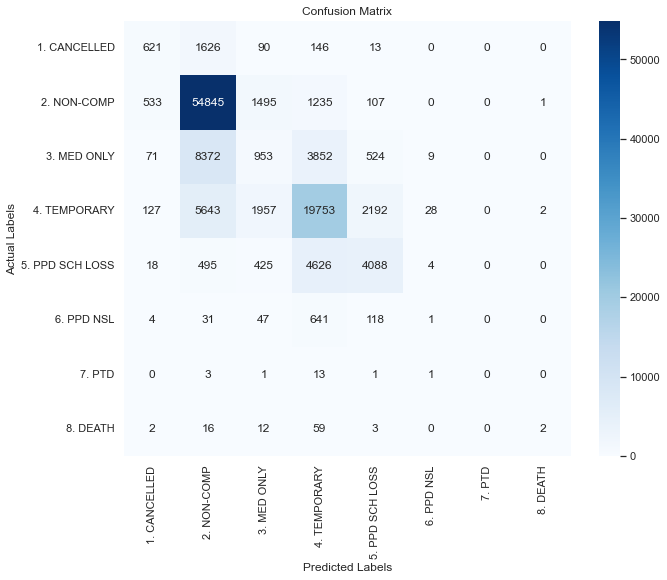

In [46]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_knn)

__Findings:__
- __Same Performance for Default and Tuned Models:__ Both the default and the tuned KNN models yield identical results, with a Validation F1-Score of __0.305__. The only difference between the models is the distance metric, where the default used 'manhattan' and the tuned model used 'euclidean,' but this did not affect performance. The lack of improvement highlights that tuning alone may not address the challenges posed by class imbalance and overlapping features.
- __Dominant Class Predictions:__ The model performs well on dominant classes, achieving an F1-Score of __0.85 for "NON-COMP"__ and __0.66 for "TEMPORARY"__. However, it continues to struggle with minority classes like __"PTD" and "DEATH"__, which show F1-Scores of __0.00 and 0.04__, respectively.
- __Class Confusion and Misclassifications:__ The confusion matrix reveals significant overlaps, particularly between "MED ONLY" and "TEMPORARY" and "PPD SCH LOSS" and "TEMPORARY". This suggests that the features are not sufficiently separable, making it challenging for KNN to distinguish similar classes.

Step 5: Prediction on Submission Test Data

In [47]:
# Predict on the submission test set
y_test_sub_pred_knn = model_knn.predict(X_test_submission)
y_test_sub_pred_decoded_knn = [inverse_target_mapping[val] for val in y_test_sub_pred_knn]

In [48]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_knn, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 6839
2. NON-COMP: 314520
3. MED ONLY: 19082
4. TEMPORARY: 44682
5. PPD SCH LOSS: 2846
6. PPD NSL: 4
8. DEATH: 2


In [49]:
# Create a submission DataFrame
submission_knn = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_knn
})

# Save the submission file
submission_knn.to_csv('submissions/Group52_VersionX_knn.csv', index=False)
print("Submission file saved as 'Group52_VersionX_knn.csv'")

Submission file saved as 'Group52_VersionX_knn.csv'


### 2.5 Neural Networks <a id='nn'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Neural Networks

In [50]:
# Create Neural Network
model_nn_default = MLPClassifier()
model_nn= MLPClassifier(activation='tanh', batch_size=32, hidden_layer_sizes=3, learning_rate='adaptive', learning_rate_init=0.01, max_iter=100, solver='sgd')

param_grid_nn = {
    'hidden_layer_sizes': [2,3],
    'activation': ['relu', 'tanh', 'sigmoid'],                                   
    'solver': ['adam','sgd', 'rmsprop'],                                       
    'batch_size': [32, 64],                                   
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],                            
    'max_iter': [100,500,1000]                                   
}

Step 2: Perform hyperparameter tuning

In [51]:
# Tune hyperparameters using the combined dataset
best_params_nn = hyperparameter_tuning(model_nn, param_grid_nn, test_fold, X_combined, y_combined)
model_nn.set_params(**best_params_nn)

Fitting 1 folds for each of 648 candidates, totalling 648 fits
The best score is 0.29386562760746854
With the parameters: {'activation': 'tanh', 'solver': 'sgd', 'batch_size': 32, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 100}



MLPClassifier(activation='tanh', batch_size=32, hidden_layer_sizes=3,
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=100,
              solver='sgd')

Step 3: Train default model and model with best parameter setting and evaluate

In [52]:
models_nn = [
    ("NN Default", model_nn_default),
    ("NN Best Params", model_nn)
]

In [53]:
# Train and evaluate on validation set
results_nn = compare_results(models_nn, X_train, X_val, y_train, y_val)
results_nn

Evaluating model: NN Default...
Evaluating model: NN Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,NN Default,143.522,0.360,0.342
1,NN Best Params,148.247,0.273,0.274


Step 4: Evaluate the choosen Model on our Test Set

In [54]:
# Evaluate on the test set
y_test_pred_nn = model_nn.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_nn = [inverse_target_mapping[val] for val in y_test_pred_nn]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_nn_best = round(f1_score(y_test_decoded, y_test_pred_decoded_nn, average='macro'), 3)
results_nn_best = results_nn[results_nn["Model"].str.contains("Best Params")].copy()
results_nn_best["Test F1-Score"] = test_f1_nn_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_nn, 'Neural Networks Model')


Classification Report for Neural Networks Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00      2496
    2. NON-COMP       0.80      1.00      0.89     58216
    3. MED ONLY       0.08      0.00      0.00     13781
   4. TEMPORARY       0.71      0.81      0.76     29702
5. PPD SCH LOSS       0.59      0.52      0.56      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.76    114806
      macro avg       0.27      0.29      0.28    114806
   weighted avg       0.65      0.76      0.69    114806



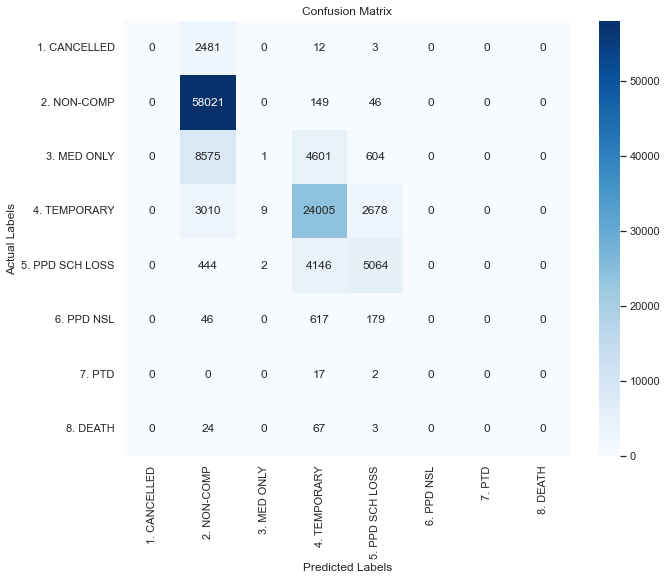

In [55]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_nn)

__Findings:__
- __Strong Performance in Majority Classes:__ The neural network model performs well for dominant classes, such as __"NON-COMP" and "TEMPORARY"__, achieving relatively high F1-scores of __0.89 and 0.76__, respectively. This indicates that the model effectively captures patterns in these frequent categories.
- __Struggles with Minority Classes:__ The model fails to classify minority classes accurately, including __"CANCELLED", "PPD NSL", "PTD", and "DEATH"__, where F1-scores are __0.00__. These low scores highlight the model’s inability to handle underrepresented categories, which is critical in imbalanced datasets.
- __Misclassification Patterns:__ The confusion matrix reveals significant misclassifications, where instances of "CANCELLED" are often predicted as "NON-COMP" or "TEMPORARY". Similar patterns are observed for other minority classes, indicating challenges in separating overlapping features.
- __Worse Performance with Tuned Parameters:__ Surprisingly, the hyperparameter-tuned model performs worse than the default configuration, with a slightly lower validation __F1-score (0.274 vs 0.342)__. Possible Explanation could be that the chosen hyperparameters, such as 'tanh' activation and 'sgd' solver, might have slowed convergence or caused the model to get stuck in local minima. Additionally, the small hidden_layer_sizes=3 may have limited the model's capacity to learn complex patterns, especially in the presence of class imbalance.

Step 5: Prediction on Submission Test Data

In [56]:
# Predict on the submission test set
y_test_sub_pred_nn = model_nn.predict(X_test_submission)
y_test_sub_pred_decoded_nn = [inverse_target_mapping[val] for val in y_test_sub_pred_nn]

In [57]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_nn, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 335654
3. MED ONLY: 6
4. TEMPORARY: 50683
5. PPD SCH LOSS: 1632


In [58]:
# Create a submission DataFrame
submission_nn = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_nn
})

# Save the submission file
submission_nn.to_csv('submissions/Group52_VersionX_nn.csv', index=False)
print("Submission file saved as 'Group52_VersionX_nn.csv'")

Submission file saved as 'Group52_VersionX_nn.csv'


### 2.6 Decision Trees <a id='dt'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Decision Trees

In [59]:
# Create Decision Tree model
model_dt_default = DecisionTreeClassifier()
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt', max_leaf_nodes=5, min_impurity_decrease=0.01, min_samples_leaf=10, min_samples_split=10, splitter='best')

# Define hyperparameter grid
param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"], # Impurity measure
    "splitter": ["best", "random"],               # Split strategy
    "max_depth": [None, 5, 10, 20, 50],           # Maximum depth of the tree
    "min_samples_split": [2, 10, 50],             # Minimum samples required to split an internal node
    "min_samples_leaf": [1, 5, 10, 50],           # Minimum samples required in a leaf node
    "max_features": [None, "sqrt", "log2"],       # Number of features to consider for best split
    "max_leaf_nodes": [None, 10, 20, 50],         # Maximum number of leaf nodes
    "min_impurity_decrease": [0.01, 0.02, 0.02]   # Decide if a node will be split according to the decrease of impurity
}

Step 2: Perform hyperparameter tuning

In [60]:
# Tune hyperparameters using the combined dataset
best_params_dt = hyperparameter_tuning(model_dt, param_grid_dt, test_fold, X_combined, y_combined)
model_dt.set_params(**best_params_dt)

Fitting 1 folds for each of 12960 candidates, totalling 12960 fits
The best score is 0.16324846458
With the parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'best'}



DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=5, min_impurity_decrease=0.01,
                       min_samples_leaf=10, min_samples_split=10)

Step 3: Train default model and model with best parameter setting and evaluate

In [61]:
models_dt = [
    ("DT Default", model_dt_default),
    ("DT Best Params", model_dt)
]

In [62]:
# Train and evaluate on validation set
results_dt = compare_results(models_dt, X_train, X_val, y_train, y_val)
results_dt

Evaluating model: DT Default...
Evaluating model: DT Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,DT Default,4.396,1.000,0.309
1,DT Best Params,0.058,0.165,0.163


Step 4: Evaluate the choosen Model on our Test Set

In [63]:
# Evaluate on the test set
y_test_pred_dt = model_dt.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_dt = [inverse_target_mapping[val] for val in y_test_pred_dt]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_dt_best = round(f1_score(y_test_decoded, y_test_pred_decoded_dt, average='macro'), 3)
results_dt_best = results_dt[results_dt["Model"].str.contains("Best Params")].copy()
results_dt_best["Test F1-Score"] = test_f1_dt_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_dt, 'Decision Tree Model')


Classification Report for Decision Tree Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00      2496
    2. NON-COMP       0.69      0.93      0.79     58216
    3. MED ONLY       0.00      0.00      0.00     13781
   4. TEMPORARY       0.47      0.57      0.51     29702
5. PPD SCH LOSS       0.00      0.00      0.00      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.62    114806
      macro avg       0.14      0.19      0.16    114806
   weighted avg       0.47      0.62      0.53    114806



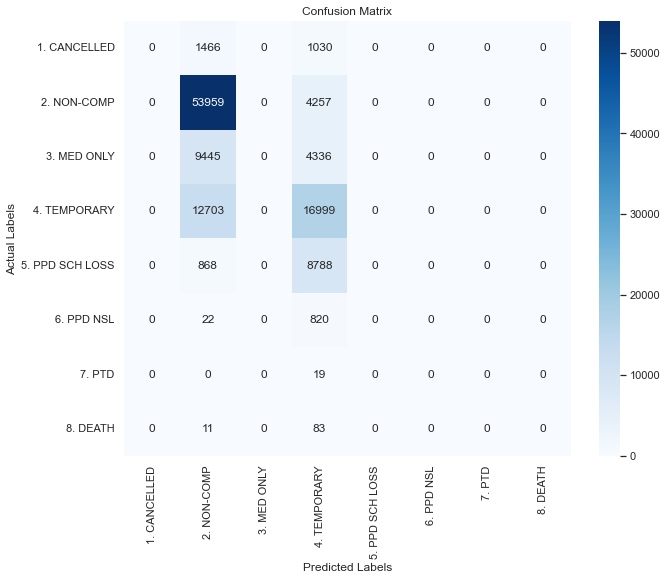

In [64]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_dt)

__Findings:__
- __Overfitting with Default Parameters:__ The Decision Tree with default settings achieved a perfect F1-Score (1.000) on the training set but performed poorly on the validation set (0.309). This behavior shows the default configuration allows the tree to grow excessively deep, capturing noise and overfitting to the training data.
- __Reduced Complexity with Tuned Parameters__: The model with optimized hyperparameters showed lower training (0.165) and validation (0.163) F1-Scores, indicating better regularization. Parameters such as max_depth=20, min_samples_split=10, and min_impurity_decrease=0.01 were set to reduce the risk of overfitting by controlling tree growth and enforcing splits only when statistically significant.
- __Weak Classification for Minority Classes__: The model struggled to classify all minority classes. F1-Scores for these classes were all 0.00. The confusion matrix highlights the tendency to misclassify most instances into dominant classes like "NON-COMP" and "TEMPORARY."
- __Default vs Tuned Parameters:__ While the tuned model avoids overfitting, its overall performance drops drastically compared to the default settings. This drop may result from excessive regularization limiting the model's ability to capture patterns.

Step 5: Prediction on Submission Test Data

In [65]:
# Predict on the submission test set
y_test_sub_pred_dt = model_dt.predict(X_test_submission)
y_test_sub_pred_decoded_dt = [inverse_target_mapping[val] for val in y_test_sub_pred_dt]

In [66]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_dt, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 306476
4. TEMPORARY: 81499


In [67]:
# Create a submission DataFrame
submission_dt = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_dt
})

# Save the submission file
submission_dt.to_csv('submissions/Group52_VersionX_dt.csv', index=False)
print("Submission file saved as 'Group52_VersionX_dt.csv'")

Submission file saved as 'Group52_VersionX_dt.csv'


### 2.7 Ensemble Learning <a id='el'></a>

In the following, we are going to use different kinds of Ensemble Learning methods. We are starting with Bagging using Decision Trees, then Random Forest, and lastly XGBoost.

### 2.7.1 Bagging Classifier <a id='bagging'></a>
[to the top](#top)

We will use Decision Trees as base estimators, since they are the most used bagging base estimators.

Step 1: Create model and define hyperparameter grid for Baaging Classifier using Decision Trees

In [68]:
# Create model
estimator_dt = DecisionTreeClassifier(max_depth=4, min_samples_split=20, min_samples_leaf=10)

model_bag_dt = BaggingClassifier(estimator=estimator_dt, n_estimators=30, max_samples=0.6, 
                                 max_features=0.7, bootstrap=True, bootstrap_features=False, random_state=42)

# Define parameter grid
param_grid_bag = {
    "n_estimators": [10, 30, 50],       # Number of decision trees
    "max_samples": [0.5, 0.7, 9.0],      # Fraction of the dataset to sample
    "max_features": [0.5, 0.6, 7.0],     # Fraction of features to sample
    "bootstrap": [True, False],          # Sampling with or without replacement
    "bootstrap_features": [True, False]  # Feature sampling with or without replacement
}

Step 2: Perform hyperparameter tuning

In [69]:
# Tune hyperparameters using the combined dataset
best_params_bag = hyperparameter_tuning(model_bag_dt, param_grid_bag, test_fold, X_combined, y_combined)
model_bag_dt.set_params(**best_params_bag)

Fitting 1 folds for each of 108 candidates, totalling 108 fits
The best score is 0.2864146898182114
With the parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 0.6, 'n_estimators': 30}



BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=0.7,
                  max_samples=0.6, n_estimators=30)

Step 3: Train default model and model with best parameter setting and evaluate

In [70]:
models_bag = [
    ("Bagging DT Best Params", model_bag_dt)
]

In [71]:
# Train and evaluate on validation set
results_bag = compare_results(models_bag, X_train, X_val, y_train, y_val)
results_bag

Evaluating model: Bagging DT Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,Bagging DT Best Params,41.32,0.927,0.319


Step 4: Evaluate the choosen Model on our Test Set

In [72]:
# Evaluate on the test set
y_test_pred_bag_dt = model_bag_dt.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_bag_dt = [inverse_target_mapping[val] for val in y_test_pred_bag_dt]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_bag_best = round(f1_score(y_test_decoded, y_test_pred_decoded_bag_dt, average='macro'), 3)
results_bag_best = results_bag[results_bag["Model"].str.contains("DT Best Params")].copy()
results_bag_best["Test F1-Score"] = test_f1_bag_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_bag_dt, 'Decision Tree Model')


Classification Report for Decision Tree Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.68      0.28      0.39      2496
    2. NON-COMP       0.82      0.97      0.89     58216
    3. MED ONLY       0.27      0.03      0.06     13781
   4. TEMPORARY       0.67      0.86      0.75     29702
5. PPD SCH LOSS       0.65      0.39      0.49      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.76    114806
      macro avg       0.39      0.32      0.32    114806
   weighted avg       0.69      0.76      0.70    114806



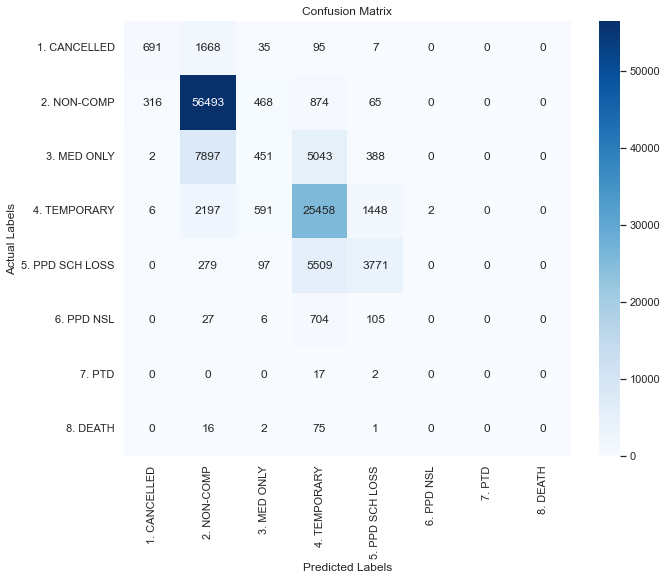

In [73]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_bag_dt)

__Findings:__
- __Overfitting Behavior:__ The Bagging Decision Tree model exhibits high overfitting, as shown by a __Train F1-Score of 0.927__ compared to a __Validation F1-Score of 0.319__. This suggests that the model effectively memorizes patterns in the training data but struggles to generalize to unseen data.
- __Performance on Majority Classes:__ The model performs well on the majority classes, such as "NON-COMP" (F1-Score: 0.89) and "TEMPORARY" (F1-Score: 0.75), resulting in a high weighted average accuracy of 76%. The dominance of these classes inflates performance metrics, masking weaknesses in identifying minority classes.
- __Poor Performance on Minority Classes:__ Predictions for minority classes remain problematic, with F1-Scores close to 0.00 for "PTD," "PPD NSL," and "DEATH." This highlights that bagging fails to handle class imbalance effectively despite its ensemble nature.
- __Class Confusion:__ The confusion matrix reveals misclassifications between "MED ONLY" and "TEMPORARY", as well as overlaps between "PPD SCH LOSS" and "TEMPORARY." This indicates challenges in distinguishing classes with similar features, even with ensemble techniques.
- __Improved Performance Compared to Base Decision Tree:__ While bagging reduces variance and provides slightly better generalization than the standalone Decision Tree, it still __suffers from bias toward majority classes and limited predictive power for minority labels.__

Step 5: Prediction on Submission Test Data

In [74]:
# Predict on the submission test set
y_test_sub_pred_bag_dt = model_bag_dt.predict(X_test_submission)
y_test_sub_pred_decoded_bag_dt = [inverse_target_mapping[val] for val in y_test_sub_pred_bag_dt]

In [75]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_bag_dt, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 6486
2. NON-COMP: 306045
3. MED ONLY: 50467
4. TEMPORARY: 22182
5. PPD SCH LOSS: 2795


In [76]:
# Create a submission DataFrame
submission_bag_dt = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_bag_dt
})

# Save the submission file
submission_bag_dt.to_csv('submissions/Group52_VersionX_bag_dt.csv', index=False)
print("Submission file saved as 'Group52_VersionX_bag_dt.csv'")

Submission file saved as 'Group52_VersionX_bag_dt.csv'


### 2.7.2 Random Forest Classifier <a id='random_forest'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Random Forest Classifier

Use _class_weight='balanced'_ to deal with the imbalanced dataset.

In [77]:
# Create model
model_rf_default = RandomForestClassifier()
model_rf = RandomForestClassifier(class_weight='balanced',max_depth=8, max_features='sqrt', 
                                  min_samples_leaf=8, min_samples_split=10, n_estimators=200)
# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 200],
    'max_depth': [5, 8, 10],
    'min_samples_split': [5, 8, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 8, 10]
}

Step 2: Perform hyperparameter tuning

In [78]:
# Tune hyperparameters using the combined dataset
best_params_rf = hyperparameter_tuning(model_rf, param_grid_rf, test_fold, X_combined, y_combined)
model_rf.set_params(**best_params_rf)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
The best score is 0.2444146898182114
With the parameters: {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 200}



RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=200)

Step 3: Train default model and model with best parameter setting and evaluate

In [79]:
models_rf = [
    ("RF Default", model_rf_default),
    ("RF Best Params", model_rf)
]

In [80]:
# Train and evaluate on the validation dataset
results_rf = compare_results(models_rf, X_train, X_val, y_train, y_val)
results_rf

Evaluating model: RF Default...
Evaluating model: RF Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,RF Default,52.501,1.000,0.327
1,RF Best Params,33.057,0.245,0.244


Step 4: Evaluate the chosen model on our Test Set

In [81]:
# Evaluate on the test set
y_test_pred_rf = model_rf.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_rf = [inverse_target_mapping[val] for val in y_test_pred_rf]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_rf_best = round(f1_score(y_test_decoded, y_test_pred_decoded_rf, average='macro'), 3)
results_rf_best = results_rf[results_rf["Model"].str.contains("Best Params")].copy()
results_rf_best["Test F1-Score"] = test_f1_rf_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_rf, 'Random Forrest Classifier')


Classification Report for Random Forrest Classifier:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00      2496
    2. NON-COMP       0.80      1.00      0.89     58216
    3. MED ONLY       0.60      0.00      0.00     13781
   4. TEMPORARY       0.67      0.89      0.76     29702
5. PPD SCH LOSS       0.84      0.20      0.32      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.75    114806
      macro avg       0.36      0.26      0.25    114806
   weighted avg       0.72      0.75      0.67    114806



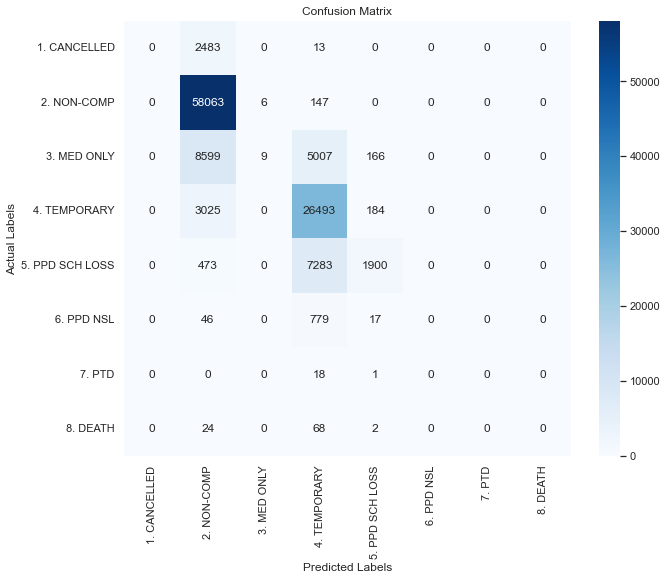

In [82]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_rf)

__Findings:__
- __Overfitting in Default Model:__ The default Random Forest model demonstrates severe overfitting with a __Train F1-Score of 1.000__ compared to a __Validation F1-Score of 0.326__. This indicates that the model perfectly memorized the training data but struggles to generalize to unseen data.
- __Impact of Hyperparameter Tuning:__ After tuning, the __Train F1-Score drops to 0.244__, and the __Validation F1-Score__ decreases slightly to __0.244__ as well. While this reduces overfitting, it also highlights the model's inability to effectively capture patterns in the dataset, potentially due to overly restrictive tuning parameters.
- __Performance in Majority Classes:__ The model performs well in dominant classes such as "NON-COMP" (F1-Score = 0.89) and "TEMPORARY" (F1-Score = 0.76). However, this bias toward majority classes contributes to a relatively high weighted average F1-Score of 0.67 and accuracy of 75%.
- Weak Performance in Minority Classes: Predictions for minority classes such as "CANCELLED," "MED ONLY," and "DEATH" remain poor, with F1-Scores of 0.00. The model is unable to detect patterns in these rare categories, leading to high misclassification rates.
- __Class Confusion and Misclassification Patterns:__ The confusion matrix shows significant misclassifications, particularly between "PPD SCH LOSS" and "TEMPORARY" as well as "MED ONLY" and "NON-COMP". These overlaps suggest the model struggles to separate classes with similar feature distributions.

Step 5: Prediction on Submission Test Data

In [83]:
y_test_sub_pred_rf = model_rf.predict(X_test_submission)
y_test_sub_pred_decoded_rf = [inverse_target_mapping[val] for val in y_test_sub_pred_rf]

In [84]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_rf, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 335755
4. TEMPORARY: 51476
5. PPD SCH LOSS: 744


In [85]:
# Create a submission DataFrame
submission_rf = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_rf
})

# Save the submission file
submission_rf.to_csv('submissions/Group52_VersionX_rf.csv', index=False)
print("Submission file saved as 'Group52_VersionX_rf.csv'")

Submission file saved as 'Group52_VersionX_rf.csv'


### 2.7.3 XGBoost <a id='xgboost'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for XGBoost Classifier

In [86]:
# Initialize XGBoost classifier
model_xgb_default = XGBClassifier()
model_xgb = XGBClassifier(
    objective='multi:softprob', num_class=8, use_label_encoder=False, 
    eval_metric='mlogloss', colsample_bytree=0.7, learning_rate=0.1, 
    max_depth=3, n_estimators=100, subsample=0.7, reg_alpha=0.1, reg_lambda=1.0
)

# Define hyperparameter grid
param_grid_xgb = {
    'max_depth': [2, 3, 5],                 # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.15],     # Step size shrinkage
    'n_estimators': [50, 100, 200],         # Number of boosting rounds
    'subsample': [0.6, 0.8, 1.0],                # Fraction of samples for each tree
    'colsample_bytree': [0.6, 0.8, 0.9]     # Fraction of features for each tree
}

Step 2: Perform hyperparameter tuning

In [87]:
# Tune hyperparameters using the combined dataset
best_params_xgb = hyperparameter_tuning(model_xgb, param_grid_xgb, test_fold, X_combined, y_combined)
model_xgb.set_params(**best_params_xgb)

Fitting 1 folds for each of 243 candidates, totalling 243 fits
The best score is 0.32145123456789
With the parameters: {'objective': 'multi:softprob', 'num_class': 8, 'use_label_encoder': False, 'eval_metric': 'mlogloss', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1.0}



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=8, num_parallel_tree=None, objective='multi:softprob', ...)

Step 3: Train default model and model with best parameter setting and evaluate

In [88]:
models_xgb = [
    ("XGBoost Default", model_xgb_default),
    ("XGBoost Best Params", model_xgb)
]

In [89]:
# Train and evaluate on validation set
results_xgb = compare_results(models_xgb, X_train, X_val, y_train, y_val)
results_xgb

Evaluating model: XGBoost Default...


Evaluating model: XGBoost Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,XGBoost Default,149.952,0.506,0.340
1,XGBoost Best Params,61.272,0.315,0.321


Step 4: Evaluate the chosen model on our Test Set

In [90]:
# Evaluate on the test set
y_test_pred_xgb = model_xgb.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_xgb = [inverse_target_mapping[val] for val in y_test_pred_xgb]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_xgb_best = round(f1_score(y_test_decoded, y_test_pred_decoded_xgb, average='macro'), 3)
results_xgb_best = results_xgb[results_xgb["Model"].str.contains("Best Params")].copy()
results_xgb_best["Test F1-Score"] = test_f1_xgb_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_xgb, 'XGBoost Classifier')


Classification Report for XGBoost Classifier:

                 precision    recall  f1-score   support

   1. CANCELLED       0.64      0.33      0.43      2496
    2. NON-COMP       0.81      0.99      0.89     58216
    3. MED ONLY       0.31      0.00      0.01     13781
   4. TEMPORARY       0.69      0.86      0.77     29702
5. PPD SCH LOSS       0.70      0.36      0.48      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       1.00      0.01      0.02        94

       accuracy                           0.76    114806
      macro avg       0.52      0.32      0.32    114806
   weighted avg       0.70      0.76      0.70    114806



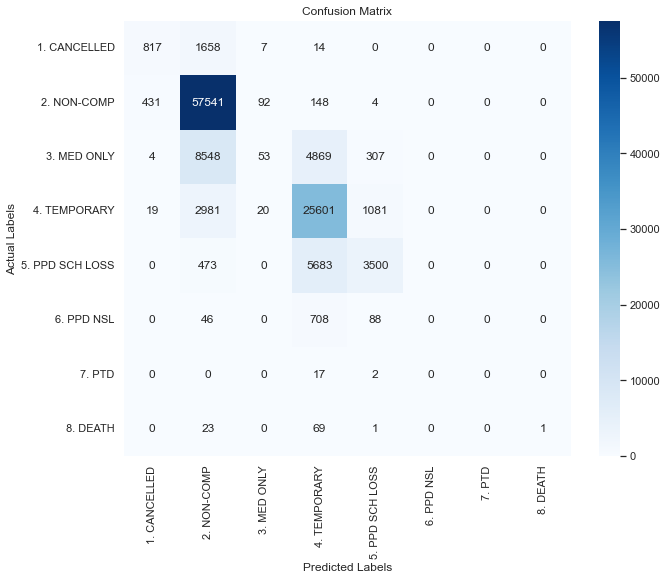

In [91]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_xgb)

__Findings:__
- __Performance Comparison:__ The __default__ XGBoost model achieved a Validation F1-Score of 0.340 and exhibited __overfitting__, with a Train F1-Score of 0.506. The tuned model, while reducing overfitting, had a Validation F1-Score of 0.321 and a lower Train F1-Score of 0.315. This indicates that the __parameter tuning significantly reduced overfitting but also slightly impacted validation performance.__
- __Dominant Class Bias:__ The classifier performed well on dominant classes like "NON-COMP" (F1-Score = 0.89) and "TEMPORARY" (F1-Score = 0.77) but failed to generalize for minority classes. For instance, "PPD NSL," "PTD," and "DEATH" all had F1-Scores of 0.00 - 0.02, demonstrating poor performance in low-support categories.
- __Class Confusion:__ The confusion matrix highlights misclassifications, especially for "MED ONLY" and "PPD SCH LOSS", which overlap with "TEMPORARY". For example, 4,869 instances of "MED ONLY" were classified as "TEMPORARY". This suggests that the feature space might not be sufficiently discriminative.
- __Macro vs. Weighted Metrics__: The macro-average F1-Score (0.32) compared to the weighted F1-Score (0.70) illustrates that the model disproportionately favors majority classes, contributing to misleadingly high accuracy (76%).

Step 5: Prediction on Submission Test Data

In [92]:
y_test_sub_pred_xgb = model_xgb.predict(X_test_submission)
y_test_sub_pred_decoded_xgb = [inverse_target_mapping[val] for val in y_test_sub_pred_xgb]

In [93]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_xgb, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 4914
2. NON-COMP: 330500
3. MED ONLY: 389
4. TEMPORARY: 51447
5. PPD SCH LOSS: 725


In [94]:
# Create a submission DataFrame
submission_xgb = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_xgb
})

# Save the submission file
submission_xgb.to_csv('submissions/Group52_VersionX_xgb.csv', index=False)
print("Submission file saved as 'Group52_VersionX_xgb.csv'")

Submission file saved as 'Group52_VersionX_xgb.csv'


### 2.8 Support Vector Machines <a id='svm'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Support Vector Machines

In [95]:
# Create model
model_svm_default = SVC(kernel='linear', decision_function_shape='ovr', max_iter=1000)
model_svm = SVC(kernel='linear', decision_function_shape='ovr', C=0.01, max_iter=1000, tol=0.0001) #decision_function_shape='ovr' -> to use svm for multicalss classification

param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    "tol": [1e-4, 1e-3, 1e-2],     # Tolerance for stopping criteria
    "max_iter": [1000, 5000, -1],  # Limit on iterations (-1 for no limit)
}

Step 2: Perform hyperparameter tuning

In [96]:
# Tune hyperparameters using the combined dataset
best_params_svm = hyperparameter_tuning(model_svm, param_grid_svm, test_fold, X_combined, y_combined)
model_svm.set_params(**best_params_svm)

Fitting 1 folds for each of 45 candidates, totalling 45 fits
The best score is 0.1103494161103081
With the parameters: {'C': 0.01, 'kernel': 'linear', 'max_iter': 1000, 'tol': 0.0001}



SVC(C=0.01, kernel='linear', max_iter=1000, tol=0.0001)

Step 3: Train default model and model with best parameter setting and evaluate

In [97]:
models_svm = [
    ("SVM Default", model_svm_default),
    ("SVM Best Params", model_svm)
]

In [98]:
# Train and evaluate on validation set
results_svm = compare_results(models_svm, X_train, X_val, y_train, y_val)
results_svm

Evaluating model: SVM Default...
Evaluating model: SVM Best Params...


,Model,Time (s),Train F1-Score,Validation F1-Score
0,SVM Default,182.666,0.178,0.172
1,SVM Best Params,191.565,0.123,0.119


Step 4: Evaluate the choosen Model on our Test Set

In [99]:
# Evaluate on the test set
y_test_pred_svm = model_svm.predict(X_test)

# Decoding the predictions (reverse transformation)
y_test_pred_decoded_svm = [inverse_target_mapping[val] for val in y_test_pred_svm]

# Calculate and save the F1 macro score on test for the best parameter model
test_f1_svm_best = round(f1_score(y_test_decoded, y_test_pred_decoded_svm, average='macro'), 3)
results_svm_best = results_svm[results_svm["Model"].str.contains("Best Params")].copy()
results_svm_best["Test F1-Score"] = test_f1_svm_best

# Classification report with the original labels
classification_report_print(y_test_decoded, y_test_pred_decoded_svm, 'Support Vector Machine')


Classification Report for Support Vector Machine:

                 precision    recall  f1-score   support

   1. CANCELLED       0.02      0.03      0.02      2496
    2. NON-COMP       0.71      0.05      0.09     58216
    3. MED ONLY       0.13      0.65      0.21     13781
   4. TEMPORARY       0.40      0.21      0.27     29702
5. PPD SCH LOSS       0.25      0.32      0.28      9656
     6. PPD NSL       0.04      0.39      0.07       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.19    114806
      macro avg       0.19      0.21      0.12    114806
   weighted avg       0.50      0.19      0.17    114806



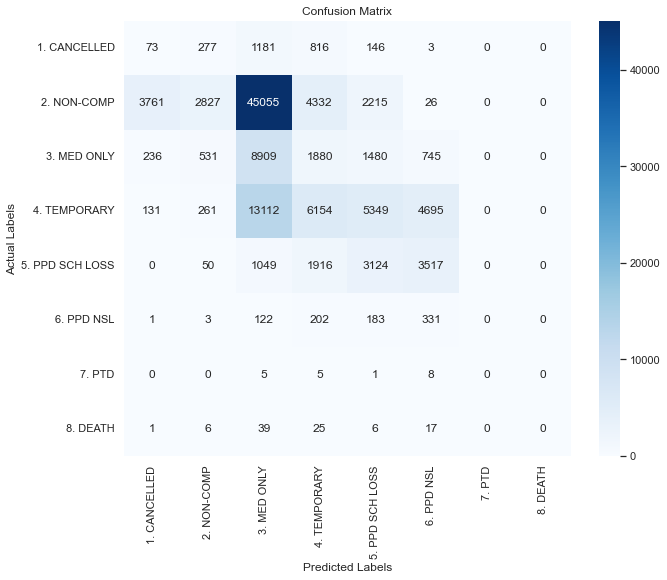

In [100]:
# Plot confusion matrix for test data
conf_matrix_plot(y_test_decoded, y_test_pred_decoded_svm)

__Findings:__
- __Poor Overall Performance:__ The default SVM model achieves a __Validation F1-Score of 0.172__, which decreases further to __0.119 after hyperparameter tuning__. This drop suggests that the tuned parameters may not be suitable for this dataset, potentially due to the complexity and imbalance in the data.
- __Underfitting and Low Generalization:__ Both the default and tuned models suffer from __underfitting__, as indicated by the low Train F1-Scores (0.178 and 0.123, respectively). This implies that the model struggles to learn meaningful patterns even from the training data.
- __Majority Class Dominance:__ Similar to other models, the SVM performs relatively better on the majority class "NON-COMP" (F1-Score = 0.09) but fails to generalize across minority classes like "PTD" and "DEATH", both achieving F1-Scores of 0.00.
- __Class Confusion and Misclassifications:__ The confusion matrix highlights significant misclassifications, particularly between similar classes such as "MED ONLY" and "TEMPORARY" or "PPD SCH LOSS" and "TEMPORARY".

Step 5: Prediction on Submission Test Data

In [101]:
# Prediction on Submission Test Data
y_test_sub_pred_svm = model_svm.predict(X_test_submission)
y_test_sub_pred_decoded_svm = [inverse_target_mapping[val] for val in y_test_sub_pred_svm]

In [102]:
unique_values, counts = np.unique(y_test_sub_pred_decoded_svm, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 2367
2. NON-COMP: 23282
3. MED ONLY: 323951
4. TEMPORARY: 25682
5. PPD SCH LOSS: 8539
6. PPD NSL: 4154


In [103]:
# Create a submission DataFrame
submission_svm = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_pred_decoded_svm
})

# Save the submission file
submission_svm.to_csv('submissions/Group52_VersionX_svm.csv', index=False)
print("Submission file saved as 'Group52_VersionX_svm.csv'")

Submission file saved as 'Group52_VersionX_svm.csv'


### 3. Comparison of all Models <a id='comparison'></a>
[to the top](#top)

Now, we are comparing the results of all models to decide which one is overall the best model.

In [104]:
# Combine all results
results_combined = pd.concat([results_lr_best, results_nb_best, results_knn_best, results_nn_best, results_dt_best, results_bag_best, results_rf_best, results_xgb_best, results_svm_best], axis=0).reset_index(drop=True)

results_combined["Algorithm"] = sum([["Logistic Regression"], ["Naive Bayes"], ["K-Nearest Neighbor"], ["Neural Networks"], ["Decision Trees"], ["DT Bagging Ensemble"], ["Random Forest Classifier"], ["XGBoost Classifier"], ["Support Vector Machines"]], [])

results_combined = results_combined[["Algorithm", "Model", "Time (s)", "Train F1-Score", "Validation F1-Score", "Test F1-Score"]]
results_combined

,Algorithm,Model,Time (s),Train F1-Score,Validation F1-Score,Test F1-Score
0,Logistic Regression,LR Best Params,7.628,0.277,0.277,0.278
1,Naive Bayes,Gaussian NB Best Params,0.106,0.070,0.070,0.072
2,K-Nearest Neighbor,KNN Best Params,0.129,0.389,0.305,0.308
3,Neural Networks,NN Best Params,148.247,0.273,0.274,0.275
4,Decision Trees,DT Best Params,0.058,0.165,0.163,0.163
5,DT Bagging Ensemble,Bagging DT Best Params,41.320,0.927,0.319,0.323
6,Random Forest Classifier,RF Best Params,33.057,0.245,0.244,0.246
7,XGBoost Classifier,XGBoost Best Params,61.272,0.315,0.321,0.324
8,Support Vector Machines,SVM Best Params,191.565,0.123,0.119,0.118


#### Overall Findings

__Best Performing Models:__
- __XGBoost__ achieved the __highest test F1-Score of 0.324__, making it the best-performing model overall. It demonstrated a __balanced performance__ across training, validation, and test datasets, indicating __better generalization__ than most other models.
- __Bagging Decision Trees__ followed closely with a __test F1-Score of 0.323__. However, it exhibited __significant overfitting__ with a train F1-Score of 0.927, suggesting it memorized patterns in the training data rather than generalizing effectively.

__Key Observations:__
- __Class Imbalance Issues:__ All models struggled with minority classes, showing poor performance in categories like "PTD" and "DEATH" where F1-Scores were close to 0.00.
- __Overfitting Challenges:__ Models like Neural Networks, Bagging DT, and Random Forest displayed high training scores but failed to replicate similar performance on validation and test datasets.
- __Computational Cost:__ Some models, such as Support Vector Machines (SVM) and Neural Networks, required significantly longer training times without substantial performance gains.
- __Simplicity vs Complexity:__ Simpler models like Logistic Regression provided moderate performance without overfitting, whereas complex models like SVM failed to capitalize on their theoretical strengths.

__Final Recommendations:__
- __XGBoost__ is recommended as the primary model due to its balanced performance and minimal overfitting.
- __Bagging Decision Trees__ can be further optimized to address overfitting and might be considered in scenarios where training time is less critical.
- As already stated earlier, __class balancing techniques__ (e.g., ADASYN) are required to improve classification performance, especially for minority classes. The results for using ADASYN can be found in the final report. For some models, it did improve the performance.

### 4. Feature Importance <a id='feature_importance'></a>
[to the top](#top)

Since XGBoost was our best performing model, we are looking at the in-built feature importance of XGBoost.

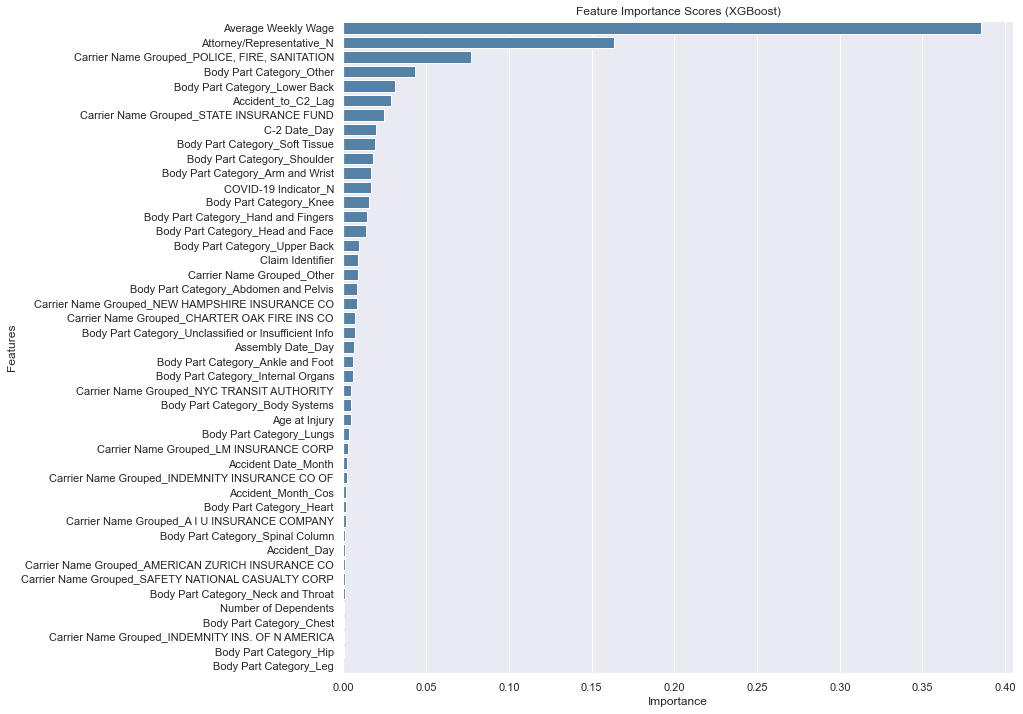

In [105]:
# Feature importance of XGBoost
feature_importance = model_xgb.feature_importances_
feature_names = list(X_train.columns)

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, color="steelblue")

plt.title("Feature Importance Scores (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")

plt.show()

__Top Features:__
1. __Average Weekly Wage:__ Most influential feature, contributing significantly to predictions.
Indicates that wage levels may be strongly correlated with claim patterns or severity.
2. __Attorney/Representative_N:__ Legal involvement appears to play a major role in claims, potentially signaling disputes or complex cases.
3. __Carrier Name Grouped_POLICE, FIRE, SANITATION:__ Suggests that claims from specific employment sectors, such as public safety, have distinct patterns.
4. __Body Part Category_Other and Lower Back:__ Body part injuries, especially lower back, seem to be recurring predictors, aligning with the commonality of back injuries in workplace claims.
5. __Accident_to_C2_Lag:__ The time gap between the accident and the claim report may influence the outcome, likely capturing delayed reporting patterns.

__Takeaways:__
- __Dominance of Economic and Injury-Related Features:__ Wage and injury type play a primary role in determining claim patterns, emphasizing the economic and physical impact of claims.
- __Sector-Specific Trends:__ Claims in public safety sectors stand out, suggesting a need for sector-specific policies or interventions.
- __Temporal Factors Matter:__ The time gap between accidents and claims influences predictions, possibly reflecting reporting behavior or delays in processing.
- __Room for Improvement:__ Some features, particularly low-impact ones, could potentially be removed or engineered further to simplify the model without sacrificing performance.


### 5. Best Model vs. Stacking <a id='stacking'></a>
[to the top](#top)

In this chapter, we compare the performance of our __best-performing model, XGBoost__, against a __stacking ensemble__ approach. Stacking is an advanced ensemble learning method that combines the predictions of multiple base models to produce a more robust and generalized output.

The motivation behind stacking lies in leveraging the strengths of multiple models, each capturing different patterns and relationships within the data. By combining these predictions, stacking can potentially overcome the weaknesses of individual models, especially in scenarios involving class imbalance or complex feature interactions.

We construct the stacking ensemble using the best parameter configurations for Naive Bayes, Decision Trees, XGBoost, Logistic Regression, and SVM as base models. The meta-model, a Multi-Layer Perceptron (MLP) classifier, is trained on the predictions of these base models to make the final decision.

In [108]:
# Define base models -> use the best parameter models
base_models = {
    'Naive Bayes': model_gauss_nb,
    'Decision Tree': model_dt,
    'XGBoost': model_xgb,
    'LR': model_lr,
    'SVM': model_svm
}

# Prepare meta-features
meta_features = np.zeros((len(y_train), len(base_models)))
meta_test_features = np.zeros((len(y_test), len(base_models)))

for i, (name, model) in enumerate(base_models.items()):
    # Train base model on training set
    model.fit(X_train, y_train)
    
    # Predict on train and test to generate meta-features
    meta_features[:, i] = model.predict(X_train)
    meta_test_features[:, i] = model.predict(X_test)

# Train meta-model
meta_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
meta_model.fit(meta_features, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

In [109]:
# Predict on training set
train_preds = meta_model.predict(meta_features)

# Compute F1 macro score for training set
f1_macro_train = f1_score(y_train, train_preds, average='macro')
print(f"Stacking Ensemble F1 Macro Score on Train Set: {f1_macro_train:.3f}")

Stacking Ensemble F1 Macro Score on Train Set: 0.319


In [110]:
# Prepare meta-features for validation set
meta_val_features = np.zeros((len(y_val), len(base_models)))

for i, (name, model) in enumerate(base_models.items()):
    meta_val_features[:, i] = model.predict(X_val)

# Predict on validation set
val_preds = meta_model.predict(meta_val_features)

# Compute F1 macro score for validation set
f1_macro_val = f1_score(y_val, val_preds, average='macro')
print(f"Stacking Ensemble F1 Macro Score on Validation Set: {f1_macro_val:.3f}")

Stacking Ensemble F1 Macro Score on Validation Set: 0.324


In [111]:
# Evaluate meta-model with F1 Macro Score
final_preds = meta_model.predict(meta_test_features)
f1_macro = f1_score(y_test, final_preds, average='macro')

print(f"Stacking Ensemble F1 Macro Score on Test Set: {f1_macro:.3f}")

Stacking Ensemble F1 Macro Score on Test Set: 0.328


__Comparision__

While the stacking ensemble performed __slightly better__ than XGBoost on the test set, the improvement was __marginal__. This suggests that the stacking approach could partially mitigate overfitting and leverage diverse patterns learned by the base models.

However, the results indicate that XGBoost remains a strong candidate, particularly due to its __computational efficiency__ and __explainability__ through feature importance scores. The stacking ensemble provides a viable alternative, especially when additional performance gains are critical, but at the cost of increased __complexity and runtime__ while only marginal improvement.

In [112]:
# Prepare meta-features for submission test set
meta_test_sub_features = np.zeros((len(X_test_submission), len(base_models)))

for i, (name, model) in enumerate(base_models.items()):
    meta_test_sub_features[:, i] = model.predict(X_test_submission)

# Predict on submission test meta-features using the meta-model
final_preds_sub = meta_model.predict(meta_test_sub_features)

y_test_sub_decoded_preds = [inverse_target_mapping[val] for val in final_preds_sub]

In [113]:
unique_values, counts = np.unique(y_test_sub_decoded_preds, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

1. CANCELLED: 4397
2. NON-COMP: 330601
3. MED ONLY: 110
4. TEMPORARY: 51627
5. PPD SCH LOSS: 1240


In [114]:
# Create a submission DataFrame
submission_stack = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_sub_decoded_preds
})

# Save the submission file
submission_stack.to_csv('submissions/Group52_VersionX_stack.csv', index=False)
print("Submission file saved as 'Group52_VersionX_stack.csv'")

Submission file saved as 'Group52_VersionX_stack.csv'


### Conclusion
- __XGBoost was the best standalone model__, balancing performance and interpretability.
- The __stacking ensemble__ offered a __minor performance boost__ but introduced __higher complexity__.
- Addressing __class imbalance__ using ADASYN slightly enhanced the performance (see report) 
- Changing feature engineering and selection could further enhance performance across all approaches